# Titanic: logistic regression

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [385]:
train = pd.read_csv('data/train.csv')

## Explore the dataset

In [386]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [387]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Look for correlations

In [388]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


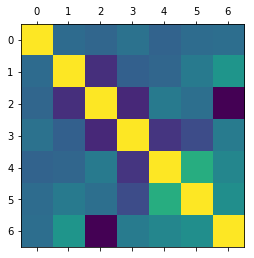

In [389]:
plt.matshow(train.corr())
plt.show()

In [390]:
train['sex_binary'] = np.where(train['Sex'].eq('male'), 1, 0)

In [391]:
train['sex_binary'].corr(train['Survived'])

-0.5433513806577551

In [392]:
train.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_binary
Sex,,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,0.0
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,1.0


In [393]:
train[train['Fare']>80].mean()

PassengerId    456.216216
Survived         0.770270
Pclass           1.000000
Age             32.371940
SibSp            0.675676
Parch            0.702703
Fare           158.678826
sex_binary       0.351351
dtype: float64

In [394]:
def prepare_input_data_for_modelling(df):
    
    ret = df.copy()
    #ret = ret.replace(r'^\s*$', np.nan, regex=True)
    ret.drop(['PassengerId', 'Name'], axis=1, inplace=True)
    for col_name in ret.columns:
        if(ret[col_name].dtype == 'object'):
            ret[col_name]= ret[col_name].astype('category')
            ret[col_name] = ret[col_name].cat.codes
        ret[col_name].fillna((ret[col_name].median()), inplace=True)
        
    return ret

In [395]:
def prepare_target_data_for_modelling(target_data):
    data = target_data[['Survived']].copy()
    return data

## Voting Classifier

In [396]:
test = pd.read_csv('data/test.csv')

In [397]:
test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Minkoff, Mr. Lazar",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [398]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [399]:
Y_train = prepare_target_data_for_modelling(train)
X_train = prepare_input_data_for_modelling(train.drop(['Survived', 'sex_binary'], axis=1))
print(X_train.describe(include='all'))

           Pclass         Sex         Age       SibSp       Parch      Ticket  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     2.308642    0.647587   29.361582    0.523008    0.381594  338.528620   
std      0.836071    0.477990   13.019697    1.102743    0.806057  200.850657   
min      1.000000    0.000000    0.420000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   22.000000    0.000000    0.000000  158.500000   
50%      3.000000    1.000000   28.000000    0.000000    0.000000  337.000000   
75%      3.000000    1.000000   35.000000    1.000000    0.000000  519.500000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  680.000000   

             Fare       Cabin    Embarked  
count  891.000000  891.000000  891.000000  
mean    32.204208   16.629630    1.529742  
std     49.693429   38.140335    0.800254  
min      0.000000   -1.000000   -1.000000  
25%      7.910400   -1.000000    1.000000  
50%   

In [400]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

vote_cls = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard', weights=[0.2,0.5,0.3])

In [401]:
vote_cls.fit(X_train, Y_train)

/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Ran...andom_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='hard',
         weights=[0.2, 0.5, 0.3])

In [402]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [403]:
X_test = prepare_input_data_for_modelling(test)
print(X_test.describe(include='all'))
Y_test = vote_cls.predict(X_test)
Y_test

           Pclass         Sex         Age       SibSp       Parch      Ticket  \
count  418.000000  418.000000  418.000000  418.000000  418.000000  418.000000   
mean     2.265550    0.636364   29.599282    0.447368    0.392344  180.944976   
std      0.841838    0.481622   12.703770    0.896760    0.981429  107.533763   
min      1.000000    0.000000    0.170000    0.000000    0.000000    0.000000   
25%      1.000000    0.000000   23.000000    0.000000    0.000000   85.250000   
50%      3.000000    1.000000   27.000000    0.000000    0.000000  181.000000   
75%      3.000000    1.000000   35.750000    1.000000    0.000000  279.750000   
max      3.000000    1.000000   76.000000    8.000000    9.000000  362.000000   

             Fare       Cabin    Embarked  
count  418.000000  418.000000  418.000000  
mean    35.576535    7.200957    1.401914  
std     55.850103   18.511330    0.854496  
min      0.000000   -1.000000    0.000000  
25%      7.895800   -1.000000    1.000000  
50%   

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [404]:
prediction = test[['PassengerId']].copy()

In [405]:
prediction['Survived'] = Y_test

In [406]:
prediction.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [407]:
prediction = prediction.set_index('PassengerId')

In [408]:
prediction.describe()

,Survived
count,418.000000
mean,0.337321
std,0.473362
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [409]:
prediction.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [410]:
prediction.to_csv('prediction/result.csv')

## Submit the prediction to Kaggle

In [411]:
!kaggle competitions submit -c titanic -f prediction/result.csv -m "Voting classifier model"

100%|████████████████████████████████████████| 2.77k/2.77k [00:08<00:00, 338B/s]
Successfully submitted to Titanic: Machine Learning from Disaster